<!-- ### Libraries -->

In [1]:
import os
from PIL import Image
import datetime
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import ast

import torch
import torchvision
import imgaug.augmenters as iaa
import timm
import torch.nn.functional as F
import torchvision.transforms.v2 as v2
from torchvision.models import convnext_base
from torchvision.transforms import functional as TF
from torch.optim.lr_scheduler import ReduceLROnPlateau
import kornia.augmentation as K
from torch import nn
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
from torch.utils.data import random_split
import random
from torch.utils.data import DataLoader
import glob
import torch
#!pip install git+https://github.com/facebookresearch/fvcore.git

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/shokoo/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_address = '/home/shokoo/EchoView/Datasets/data_split/'
files_address = '/home/shokoo/EchoView/view_classification'

In [3]:
paths = glob.glob(os.path.join(dataset_address + '**/*/*', '*')) #numebr of all samples per patients

In [4]:
avg_data_mean = np.array([0.0847569 , 0.08113708, 0.08339239])
avg_data_std = np.array([0.17340048, 0.17009241, 0.17395345])

<!-- ### Load the csv file containing the image file names and corresponding labels -->

In [5]:
info_train = pd.read_csv(os.path.join(files_address, 'csv_files/train_video_eqspaced.csv'))
info_val = pd.read_csv(os.path.join(files_address, 'csv_files/val_video_eqspaced.csv'))
info_test = pd.read_csv(os.path.join(files_address, 'csv_files/test_video_eqspaced.csv'))

In [6]:
len(info_train['label']), len(info_val['label']), len(info_test['label']), 

(4365, 1055, 1426)

In [7]:
def visualize_normalized(image, label, mean, std):
    # Un-normalize
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image = image * std + mean  # reverse normalization

    # Convert to [0, 1] and clamp to avoid display issues
    image = torch.clamp(image, 0, 1)

    # Convert to HWC
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(image_np)
    plt.title(f"Label: {label.item()}")
    plt.axis('off')
    plt.show()


<!-- ### Preprocessing -->

<!-- ##### Define Transformers -->

In [8]:
class AddGaussianNoise(nn.Module):
    """Add Gaussian noise to a video."""
    def __init__(self, mean=0., std=0.1):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
class MotionBlurWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.blur = K.RandomMotionBlur(kernel_size=5, angle=[-10., 10.], direction=[-0.5, 0.5], p=1.0)

    def forward(self, x):
        return self.blur(x.unsqueeze(0)).squeeze(0)
    
class RandomErasingWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.coarse_dropout = K.RandomErasing(scale=(0.015, 0.04), ratio=(0.2, 3.3), p=0.2)

    def forward(self, x):
        return self.coarse_dropout(x.unsqueeze(0)).squeeze(0)

class QualityDecay(nn.Module):
    def __init__(self, strength=0.5, mode="noise_blur"):
        super().__init__()
        self.strength = strength
        self._deterministic = False
        self.mode = mode

    def set_deterministic(self):
        self._deterministic = True

    def forward(self, x):
        C, H, W = x.shape
        device = x.device

        # Create vertical + radial mask (0 at top/edge, 1 at bottom/center)
        y = torch.linspace(0, 1, H, device=device).unsqueeze(1).repeat(1, W)  # vertical gradient
        x_pos = torch.linspace(-1, 1, W, device=device).unsqueeze(0).repeat(H, 1)  # horizontal wedge
        r = torch.sqrt(x_pos**2 + (y - 0.5)**2)
        decay_mask = ((0.3 * y + 0.7 * r) ).clamp(0, 1)

        decay_mask = decay_mask.unsqueeze(0).repeat(C, 1, 1)  # [C, H, W]

        if self.mode == "noise_blur":
            if self._deterministic:
                self._noise = torch.randn_like(x) * self.strength
                noise = self._noise * decay_mask
            else:
                noise = torch.randn_like(x) * decay_mask * self.strength
            x = x + noise
            # Apply slight blur by average pooling, weighted by mask
            blurred = F.avg_pool2d(x.unsqueeze(0), 3, stride=1, padding=1).squeeze(0)
            x = (1 - decay_mask) * x + decay_mask * blurred

        elif self.mode == "contrast_drop":
            mean = x.mean(dim=(1, 2), keepdim=True)
            x = (1 - decay_mask) * x + decay_mask * mean  # pull toward mean (less contrast)

        return x
    
class RandomSectorCrop(nn.Module):
    def __init__(self, width_range=(0.5, 1.0), fill=0):
        super().__init__()
        self.width_range = width_range
        self.fill = fill
        self._diterministic = None
    
    def set_deterministic(self, img_shape=None):
        if img_shape is not None:
            _, W, _ = img_shape
        else:
            W = 224  # fallback, needs a proper size
        scale_w = torch.empty(1).uniform_(*self.width_range).item()
        new_W = int(W * scale_w)
        self._diterministic = new_W
    
    def forward(self, img):
        _, W, H = img.shape
        # scale_w = torch.empty(1).uniform_(*self.width_range).item()
        # new_W = int(W * scale_w)

        new_W = self._diterministic

        center = W//2
        left = max(center - new_W//2, 0)
        right = left + new_W
 
        cropped = img[:, :, left:right]

        pad_left = (W - new_W) // 2
        pad_right = W - new_W - pad_left
        
        padded = TF.pad(cropped, [pad_left, 0, pad_right, 0], fill=self.fill)

        return padded

class ImgAugWrapper:
    def __init__(self, augmenter):
        self.augmenter = augmenter
        self.det_augmenter = None

    def set_deterministic(self):
        self.det_augmenter = self.augmenter.to_deterministic()

    def __call__(self, frames: torch.Tensor) -> torch.Tensor:
        is_single = frames.dim() == 3
        if is_single:
            frames = frames.unsqueeze(0)  # [1, C, H, W]

        frames_np = (frames.permute(0, 2, 3, 1).cpu().numpy() * 255).astype(np.uint8)
        
        augmented_np = self.det_augmenter(images=frames_np)
        augmented = torch.from_numpy(augmented_np).float() / 255.0
        augmented = augmented.permute(0, 3, 1, 2)

        if is_single:
            return augmented[0]
        return augmented

    @property
    def name(self):
        return self.augmenter.name if hasattr(self.augmenter, 'name') else str(self.augmenter)

    def __repr__(self):
        return f"ImgAugWrapper({self.name})"

In [9]:
class VideoAugmentation(nn.Module):
    def __init__(self, augmentations, num_select=2, seed=None):
        super().__init__()
        self.augmentations = augmentations
        self.num_select = num_select
        self.seed = seed

    def forward(self, video_tensor: torch.Tensor):

        first_frame_shape = video_tensor[0].shape

        for aug in self.augmentations:
            if isinstance(aug, ImgAugWrapper):
                aug.set_deterministic()
            elif hasattr(aug, "set_deterministic"):
                if "img_shape" in aug.set_deterministic.__code__.co_varnames:
                    aug.set_deterministic(img_shape=first_frame_shape) #pass image shape as argument
                else:
                    aug.set_deterministic()

        selected = random.sample(self.augmentations, k=self.num_select)

        for aug in selected:
            video_tensor = torch.stack([aug(frame) for frame in video_tensor])

        return video_tensor

In [98]:
original_size = (224, 224) 

video_augs = [
    QualityDecay(strength=0.3, mode='contrast_drop'),
    RandomSectorCrop(width_range=(0.45, 0.8)),
    ImgAugWrapper(iaa.KeepSizeByResize(iaa.Crop(percent=(0.2, 0.2, 0.2, 0.2)))),
    ImgAugWrapper(iaa.Fliplr(0.5)), #horizontally
    ImgAugWrapper(iaa.Flipud(0.5)), #vetrically
    ImgAugWrapper(iaa.GammaContrast((0.8, 1.2))),
    ImgAugWrapper(iaa.SigmoidContrast(gain=(5, 10))),
    ImgAugWrapper(iaa.LogContrast(gain=(0.8, 1.2))),
    ImgAugWrapper(iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255))),
    ImgAugWrapper(iaa.GaussianBlur(sigma=(0, 1.5))),
    ImgAugWrapper(iaa.CoarseDropout((0.02, 0.1), size_percent=(0.05, 0.05), per_channel=False)),
    ImgAugWrapper(iaa.Affine(scale=(0.9, 1.1), translate_percent=(-0.05, 0.05), rotate=(-15, 15), shear=(-8, 8), mode='constant', cval=0)),
    ImgAugWrapper(iaa.PerspectiveTransform(scale=(0.01, 0.05), mode='constant', cval=0)),
]
video_aug_pipeline = VideoAugmentation(video_augs, num_select=4)

aug_name_list = []
for aug in video_augs:
    if isinstance(aug, ImgAugWrapper):
        aug_name_list.append(aug.name.split('Unnamed')[-1])
    else:
        aug_name_list.append(aug.__class__.__name__)

<!-- ### Map images to their labels -->

In [99]:
import torch
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os
import ast
import cv2

class TTEDataset(Dataset):
    def __init__(self, csv_info, root_dir, data_mean=0.5, data_std=0.5,
                 use_npy=True, transform=None, remove_ecg=True, remove_static=True):
        self.meta = csv_info
        self.root_dir = root_dir
        self.data_mean = data_mean
        self.data_std = data_std
        self.use_npy = use_npy
        self.transform = transform
        self.remove_ecg = remove_ecg
        self.remove_static = remove_static
        self.label_mapping = {
            'PLAX': 0, 'PSAX-ves': 1, 'PSAX-base': 2, 'PSAX-mid': 3,
            'PSAX-apical': 4, 'Apical-2ch': 5, 'Apical-3ch': 6,
            'Apical-5ch': 7, 'Apical-4ch': 8, 'Suprasternal': 9, 'Subcostal': 10
        }

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        path = row['path']
        case_path = os.path.basename(path)
        frame_ids = ast.literal_eval(row['frame'])
        label = torch.tensor(self.label_mapping[row['label']], dtype=torch.long)

        # Load images
        images = []
        for frame_id in frame_ids:
            img_path = os.path.join(self.root_dir, path, f"{case_path}_{frame_id}.png")
            image = Image.open(img_path).convert("RGB")
            images.append(np.array(image))  # Save as numpy arrays for preprocessing

        # ECG Removal
        if self.remove_ecg:
            images = self.remove_ecg_line(images)

        # Background Removal
        if self.remove_static:
            images = self.remove_static_background(images)

        # Convert to tensor: [T, C, H, W]
        frames_tensor = torch.stack([self.ensure_tensor_rgb(img) for img in images])

        # Apply optional transforms (assumed batch-safe)
        if self.transform:
            frames_tensor = video_aug_pipeline(frames_tensor)

        # Resize and normalize
        processed_frames = []
        for frame in frames_tensor:
            frame = transforms.Grayscale(num_output_channels=3)(frame)
            frame = TF.resize(frame, size=[224, 224])
            frame = TF.normalize(frame, mean=self.data_mean, std=self.data_std)
            processed_frames.append(frame)
            
        frames_tensor = torch.stack(processed_frames)


        return frames_tensor, label

    def ensure_tensor_rgb(self, image):
        if isinstance(image, np.ndarray):
            image = torch.tensor(image).float() / 255.0
            image = image.permute(2, 0, 1)  # [H, W, C] → [C, H, W]
        elif isinstance(image, Image.Image):
            image = TF.to_tensor(image)
        elif isinstance(image, torch.Tensor):
            if image.max() > 1.0:
                image = image / 255.0
        return image

    def remove_ecg_line(self, images):
        output = []
        for img in images:
            hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HSV)
            mask = cv2.inRange(hsv, (40, 40, 40), (80, 255, 255))
            img[mask > 0] = 0
            output.append(img)
        return output

    def remove_static_background(self, images):
        image_array = torch.stack([TF.to_tensor(img) for img in images])
        if image_array.max() > 1.0:
            image_array /= 255.0

        slices, ch, height, width = image_array.shape
        mask = torch.zeros((ch, height, width), dtype=torch.uint8)
        steps = min(5, slices)
        for i in range(steps - 1):
            mask |= (image_array[i] != image_array[i + 1])  # element-wise comparison
        output = image_array * mask  # static pixels become zero
        return output


<!-- ### Load the train,val,test dataset from the folder -->

In [100]:
train_data = TTEDataset(
    csv_info=info_train, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True, 
    transform=True,
)

val_data = TTEDataset(
    csv_info=info_val, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True,
)

test_data = TTEDataset( 
    csv_info=info_test, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True 
)

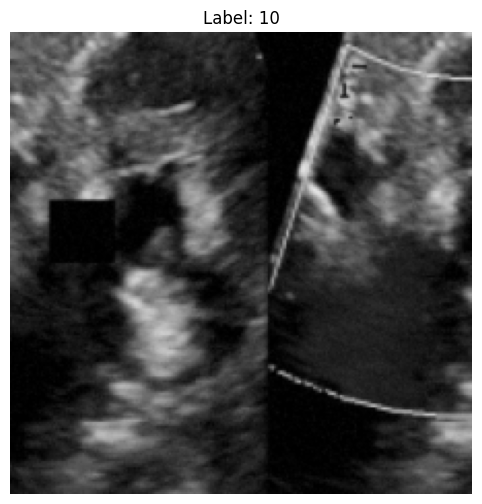

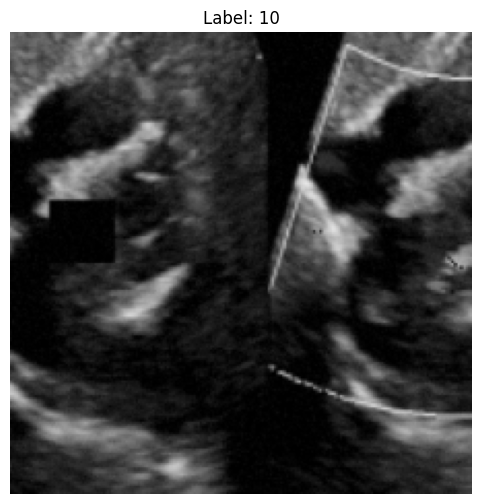

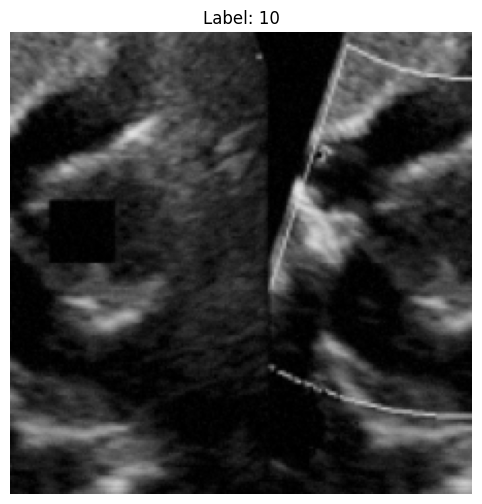

In [108]:
num = random.randint(0,1100)
img, label = train_data[num]
for i in range(0,9,4):
    visualize_normalized(img[i,:,:], label, avg_data_mean, avg_data_std)

<!-- ### Create data loaders for the train and validation sets
 -->


In [109]:
train_loader = DataLoader(train_data, batch_size=16, drop_last=False, shuffle=True,)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=16, drop_last=False, shuffle=False, )
# collate_fn=collate_fn)
# #pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=16, drop_last=False, shuffle=False,)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [15]:
# for i,l in train_loader:
#     print(i.shape)
#     break

<!-- ### Define the neural network model architecture -->

In [15]:
combined_view_map = {
    0 : 'plax',          # PLAX
    1: 'psax-ves',     # PSAX-ves
    2: 'psax-sub',     # PSAX-base
    3: 'psax-sub',     # PSAX-mid
    4: 'psax-sub',     # PSAX-apical
    5: 'apical-2ch',   # Apical-2ch
    6: 'apical-3ch',   # Apical-3ch
    7: 'apical-4&5ch',   # Apical-5ch
    8: 'apical-4&5ch',   # Apical-4ch
    9: 'suprasternal',   # Suprasternal   
    10: 'subcostal'      # Subcostal
}

class Spatial_Temporal(nn.Module):
    def __init__(self, backbone_type='convnext_base', num_classes= 11, hidden_dim= 128):
        super(Spatial_Temporal, self).__init__()

        self.group_names = ['plax', 'psax-ves', 'psax-sub', 'apical-2ch', 'apical-3ch', 'apical-4&5ch', 'suprasternal', 'subcostal']
        self.view_id_to_group_idx = {
            view_id: self.group_names.index(combined_view_map[view_id])
            for view_id in range(11)
        }

        # base_model = torchvision.models.efficientnet_b2(weights='DEFAULT')
        # self.features = base_model.features
        # feature_channels = 1408

        base_model = torchvision.models.resnet18(weights='DEFAULT')
        self.features = nn.Sequential(*list(base_model.children())[:-2])
        feature_channels = 512

        # base_model = getattr(torchvision.models, backbone_type)(weights='IMAGENET1K_V1')
        # self.features = base_model.features
        # feature_channels = 768

            
        self.dropout2d = nn.Dropout2d(p=0.2)
        self.spatial_pool = nn.AdaptiveAvgPool2d((4,4))
        self.flatten = nn.Flatten(start_dim=2) # flatten H and W

        self.rnn = nn.GRU( feature_channels * 4 * 4, hidden_dim, batch_first=True, bidirectional=True )

        self.tempora_name = self.rnn.__class__.__name__

        self.temporal_attention = nn.Sequential( 
            nn.Linear(hidden_dim * 2, hidden_dim//2 ),
            nn.Tanh(),
            nn.Linear(hidden_dim//2, 1)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, num_classes)
        )

    def forward(self, x):
        B, T, C, H, W = x.size()
        x = x.view(B * T, C, H, W)
        x = self.features(x) # [B*T, C, H', W']
        x = self.spatial_pool(x) # [B*T, C, 4, 4]
        x = self.dropout2d(x)
        x = self.flatten(x).view(B, T, -1) # [B, T, C*H*W]

        rnn_out, _ = self.rnn(x) # [B, T, 2*hidden]
        attn_weights = torch.softmax(self.temporal_attention(rnn_out), dim = 1) # [B, T, 1]
        x = torch.sum(rnn_out * attn_weights, dim = 1) # [B, hidden]
        
        x = self.classifier(x)
        return x
    
backbone_type = 'resnet18'
temporal_type = 'GRU'
num_classes = 8
model = Spatial_Temporal(backbone_type=backbone_type, num_classes=num_classes) #Convnext_FC (model name without CBAM)

In [16]:
model_parameters = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {model_parameters:,}")
param_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
param_size_mb = param_size_bytes / (1024 ** 2)
print(f"Model size (parameters): {param_size_mb:.2f} MB")
buffer_size_bytes = sum(b.numel() * b.element_size() for b in model.buffers())
total_size_mb = (param_size_bytes + buffer_size_bytes) / (1024 ** 2)
print(f"Total model size (parameters + buffers): {total_size_mb:.2f} MB")

Total parameters: 17,586,377
Model size (parameters): 67.09 MB
Total model size (parameters + buffers): 67.12 MB


In [9]:
input1 = torch.rand(32, 10, 3, 224, 224)
print(model(input1).shape)

torch.Size([32, 8])


<!-- ### Freeze initial layers of the model -->

In [ ]:
def freeze_backbone(model):
    for param in model.features.parameters():
        param.requires_grad = False

In [ ]:
def unfreeze_backbone(model):
    for param in model.features.parameters():
        param.requires_grad = True

<!-- ### Define loss and optimizer -->

In [121]:
class PenalizedCrossEntropyLoss(nn.Module):
    def __init__(self, num_classes, penalty_map=None, base_loss_weight=1.0):
        super().__init__()
        self.base_loss_weight = base_loss_weight
        self.penalty_map = penalty_map or {}
        self.ce = nn.CrossEntropyLoss(reduction='none')  # compute per-sample loss

    def forward(self, logits, targets):
        preds = torch.argmax(logits, dim=1)
        base_losses = self.ce(logits, targets)

        # Apply penalties for specific (true_label, pred_label) combinations
        penalties = torch.ones_like(base_losses) * self.base_loss_weight

        for i in range(len(targets)):
            true_label = targets[i].item()
            pred_label = preds[i].item()
            if (true_label, pred_label) in self.penalty_map:
                penalties[i] *= self.penalty_map[(true_label, pred_label)]

        penalized_loss = base_losses * penalties
        return penalized_loss.mean()

penalty_map = {
    (5, 3): 3.0,   # true: 5 (Apical-2ch), predicted as 8 (Apical-4ch) → very bad
    (5, 4): 3.0,   # true: 5, predicted as 7 → bad
    (3, 4): 3.0,
    (3, 5): 3.0,
    (4, 5): 4.0,
    (4, 3): 3.0
}

In [122]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion_nomral = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = PenalizedCrossEntropyLoss(num_classes=8, penalty_map=penalty_map)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# , weight_decay=1e-5) ## changed from 0.001 to 0.0001 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def update_optimizer(model, new_lr):
    return torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=new_lr, weight_decay=1e-5)

print(device)

cuda


In [132]:
def confusion_matrix_plt(true_labels, pred_labels, count_cm = True):

    labels_name = ['plax', 'psax-ves', 'psax-sub', 'apical-2ch', 'apical-3ch', 'apical-4&5ch', 'suprasternal', 'subcostal']

    # labels_name = valid_labels.keys()
    cm = confusion_matrix(true_labels, pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if count_cm:        
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

    plt.figure(figsize=(10,7))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

<!-- ### Train the model -->

In [138]:
def evaluate(model, loader, device, epoch, mode='validation'):
  model.eval()
  running_loss = 0.
  running_corrects_view = 0
  running_corrects_group = 0
  predicted_labels = []
  true_labels = []

  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze()
    with torch.no_grad():
      view_logits = model(images)
      new_labels = torch.tensor([model.view_id_to_group_idx[v.item()] for v in labels], device=device)
      # group_targets = torch.tensor([model.view_id_to_group_idx2[v.item()] for v in new_labels], device=device)
      # group_loss = criterion_nomral(group_logits, group_targets)
      view_loss = criterion_nomral(view_logits, new_labels)
      loss = view_loss
      total += images.size(0)
      _, predictions_view = view_logits.max(1)
    # _, predictions_group = group_logits.max(1)
    running_loss += loss.item() * images.size(0)
    running_corrects_view += (predictions_view == new_labels).sum()
    # running_corrects_group += (predictions_group == group_targets).sum()
    predicted_labels.extend(predictions_view.cpu().numpy())
    true_labels.extend(new_labels.cpu().numpy())

  epoch_loss = running_loss / total
  confusion_matrix_plt(true_labels, predicted_labels, False)
  # epoch_acc_group = running_corrects_group / total
  epoch_acc_view = running_corrects_view / total
  print(f'{mode} epoch {epoch}:  Loss({epoch_loss:6.4f}, Accuracy View ({epoch_acc_view:6.5f}) )')
  # print(f'{mode} epoch {epoch}:  Loss({epoch_loss:6.4f}, Accuracy Group ({epoch_acc_group:6.5f}), Accuracy View ({epoch_acc_view:6.5f}) )')
  return epoch_acc_view, loss


Train epoch 0: Loss(0.7445, Accuracy View (0.90034) )


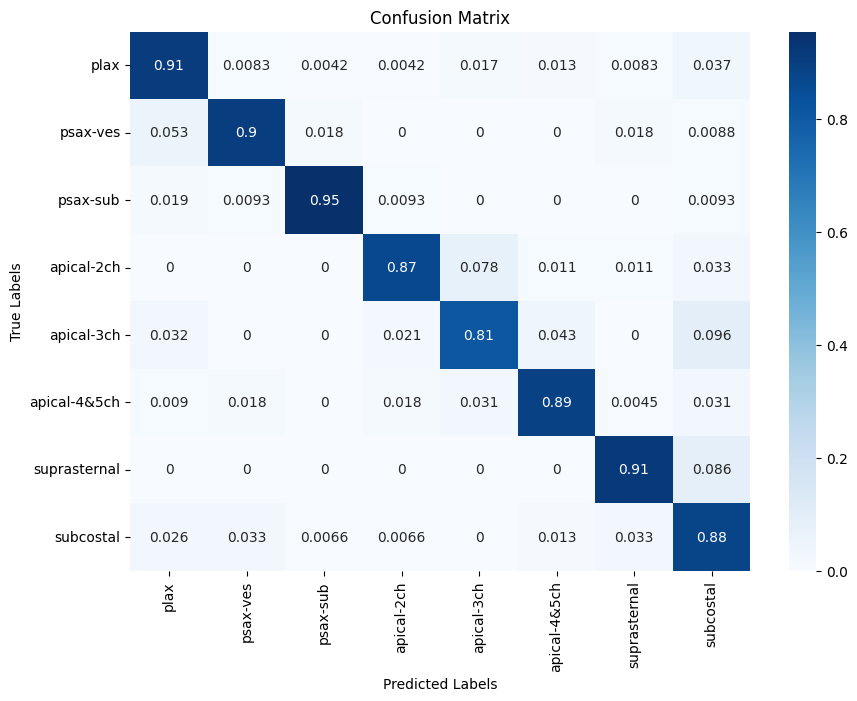

valid epoch 0:  Loss(0.7506, Accuracy View (0.89194) )
---
Train epoch 1: Loss(0.7044, Accuracy View (0.91065) )


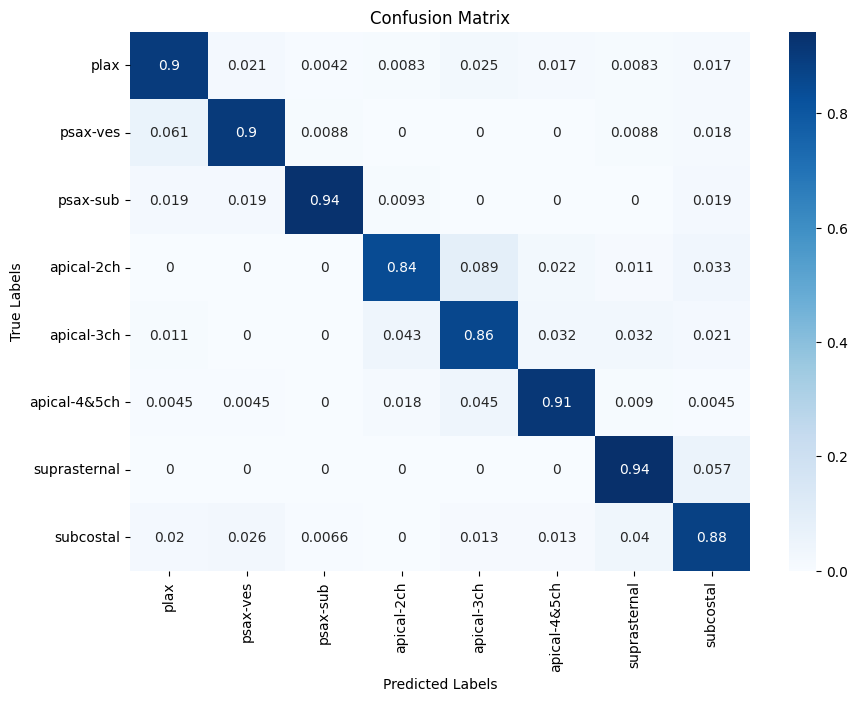

valid epoch 1:  Loss(0.7337, Accuracy View (0.89763) )
---
Train epoch 2: Loss(0.6823, Accuracy View (0.91890) )


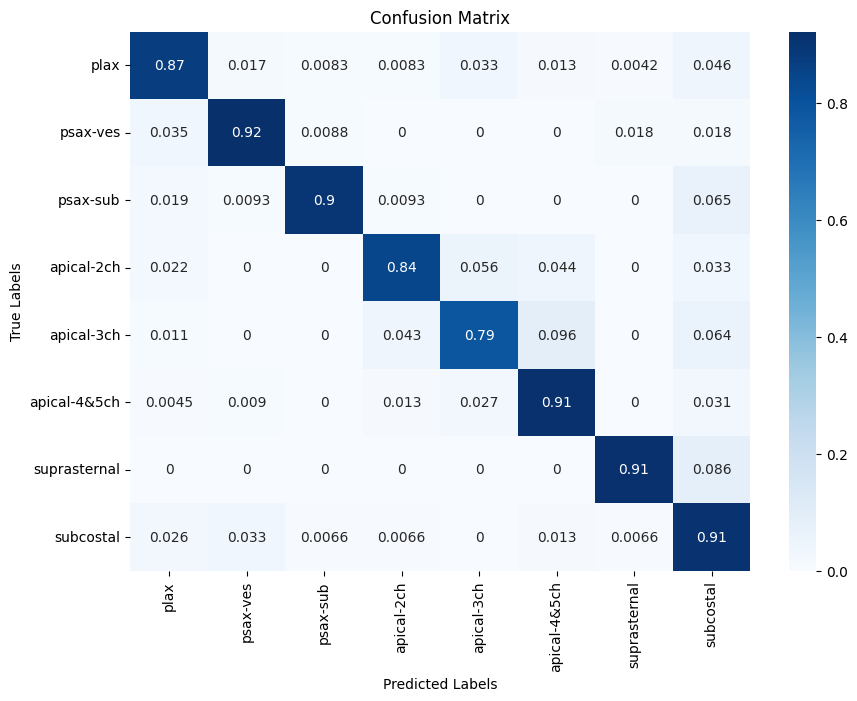

valid epoch 2:  Loss(0.7508, Accuracy View (0.88531) )
---
Train epoch 3: Loss(0.6721, Accuracy View (0.92119) )


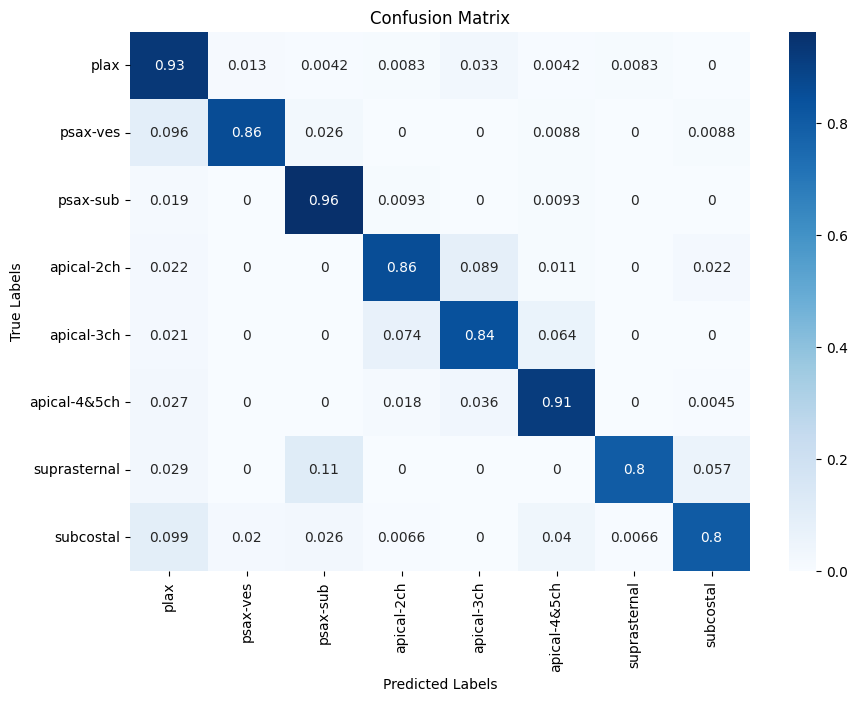

valid epoch 3:  Loss(0.7484, Accuracy View (0.88531) )
---
Train epoch 4: Loss(0.6769, Accuracy View (0.91661) )


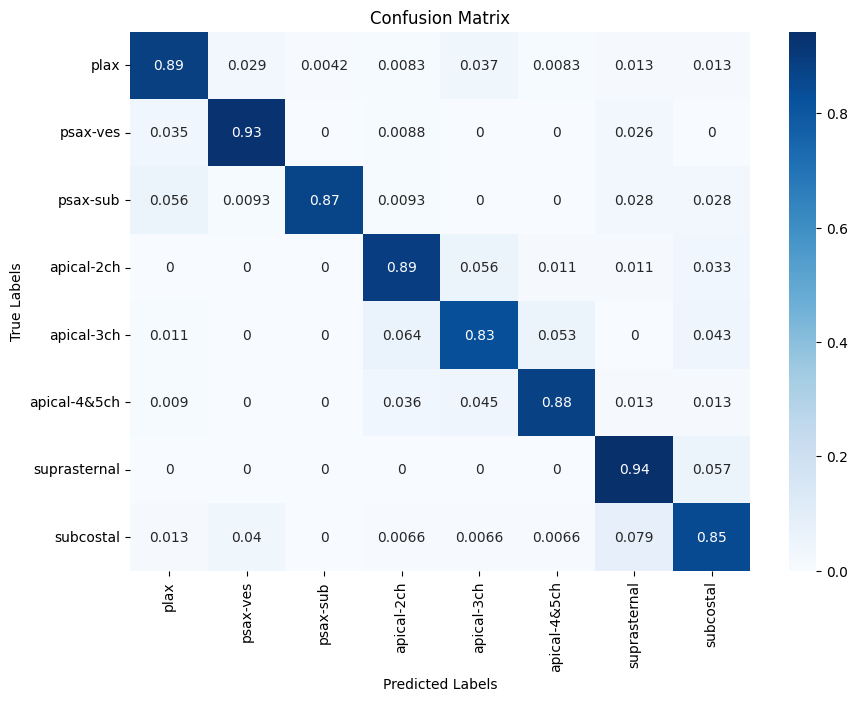

valid epoch 4:  Loss(0.7553, Accuracy View (0.88057) )
---
no further improvement  tensor(0.8853, device='cuda:0')


In [139]:
epochs = 15
backbone_freeze_epoch = 3
best_acc = 0
val_loss = 0.0
best_val_loss = float('inf')
best_model = None

# freeze_backbone(model)
# print("Backbone frozen.")

for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects_view = 0
  running_corrects_group = 0

  # if epoch == backbone_freeze_epoch:
  #   unfreeze_backbone(model)
  #   update_optimizer(model, new_lr=1e-5)
  #   print("Backbone unfrozen, optimizer updated.")

  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    view_logits = model(images)
    labels = labels.squeeze()
    new_labels = torch.tensor([model.view_id_to_group_idx[v.item()] for v in labels], device=device)
    # group_targets = torch.tensor([model.view_id_to_group_idx2[v.item()] for v in new_labels], device=device)
    # group_loss = criterion_nomral(group_logits, group_targets)
    view_loss = criterion_nomral(view_logits, new_labels)
    loss = view_loss
    loss.backward()
    optimizer.step()

    total += images.size(0)
    _, predictions_view = view_logits.max(1)
    # _, predictions_group = group_logits.max(1)
    running_loss += loss.item() * images.size(0)
    running_corrects_view += (predictions_view == new_labels).sum()
    # running_corrects_group += (predictions_group == group_targets).sum()

  epoch_loss = running_loss / total
  # epoch_acc_group = running_corrects_group / total
  epoch_acc_view = running_corrects_view / total

  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy View ({epoch_acc_view:6.5f}) )')
  val_acc_view, val_loss = evaluate(model, val_loader, device, epoch, mode='valid')

  print('---')

  if(val_loss < best_val_loss):
    best_acc = val_acc_view
    best_val_loss = val_loss
    epochs_no_improve = 0
    best_model = copy.deepcopy(model)
#     torch.save(model.state_dict(), (f'/home/student/shokoofa/Downloads/res_model{epoch}.pth'))
  else:
    epochs_no_improve += 1

  if epochs_no_improve >= 2 and epoch >= 1 :
    print('no further improvement ', best_acc)
    break


In [148]:
torch.save({
    'model_name': 'f{model.__class__.__name__}',
    'num_classes': f'{num_classes}',
    'discription': f'video model with weighted loss, and a pretrained convnext model ({model.__class__.__name__}) using {backbone_type} as backbone and {temporal_type} as temporal model + temporal attention with {num_classes} classes, including {[i for i in aug_name_list]} in augmentation, images shape is {img.shape}',
    'accuracyOnVal' : round(val_acc_view.item(),3),
    'date': str(datetime.datetime.now()).split('.')[0],
    'state_dict': model.state_dict(),
    'model' : model,
}, os.path.join(files_address, 'notebooks/saved_models/video', f'model_{model.__class__.__name__}-bb_({backbone_type})-tm_({temporal_type})-nclasses_{num_classes}-acc_{round(val_acc_view.item(),3)}-contrast_removed-{str(datetime.datetime.now()).split(".")[0]}.pth'))

In [144]:
model = best_model if best_model != None else model
val_acc_view = best_acc

<!-- #### Load a Pretrained Model -->

In [ ]:
loaded_info = torch.load(os.path.join(files_address, 'notebooks/saved_models/video', 'model_MultiViewClassifier-bb_(convnext_small)-nclasses_8-acc_0.891-contrast_removed-2025-06-10 11:21:25.pth'))
model = loaded_info['model']
description = loaded_info['discription']
description

# # state_dict = torch.load('/home/shokoo/EchoView/video_class/singleframe/test3.pth', map_location='cpu')
# # new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
# # model.load_state_dict(new_state_dict)
# # model.to(device)
# # val_acc, val_loss = evaluate(model, val_loader, device, mode='valid')

"after removing contrast images, usig upsampled csv files, adding more augmentations to the specific view and with a weighted loss model to penalize misclassifying 2 and 3, and 4&5 chambers , and a pretrained convnext model (MultiViewClassifier) combining views first with psax, plax and other group then with 8 classes, trained with convnext_small backbone, two-stage classification model, including ['RandomHorizontalFlip', 'RandomVerticalFlip', 'MotionBlurWrapper', 'QualityDecay', 'CenterCrop', 'Resize', 'RandomSectorCrop'] in augmentation, images shape is torch.Size([3, 224, 224])"

In [145]:
def evaluate_test(model, loader, device, mode='Test'):
  model.eval()
  total_correct = 0
  total_loss = 0
  indices = []
  predicted_labels = []
  true_labels = []
  confidences = []
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze()
    with torch.no_grad():
      outputs = model(images)
      # loss = criterion(outputs, labels)
      # total_loss += loss.item() * images.size(0)
      batch_start = i * loader.batch_size
      batch_indices = list(range(batch_start, batch_start + images.size(0)))
      total += images.size(0) 
      _, predictions = outputs.max(1)
      new_labels = torch.tensor([model.view_id_to_group_idx[v.item()] for v in labels], device=device)
      total_correct += (new_labels == predictions).sum()
      confidence = torch.softmax(outputs, dim=1)
      confidences.extend(confidence.cpu().numpy())
      indices.extend(batch_indices)
      predicted_labels.extend(predictions.cpu().numpy())
      true_labels.extend(new_labels.cpu().numpy())

  # print(total_correct, total, accuracy)
  # loss = total_loss / total
  accuracy = total_correct / total
  # print(f'{mode} Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  print(f'{mode}  Accuracy ({accuracy:6.4f}))')
  test_dict = {'indices': indices, 'predicted': predicted_labels, 'true_labels': true_labels, 'confidence': confidences }
  return accuracy, pd.DataFrame(test_dict)

_, test_dict = evaluate_test(model, loader= test_loader, device = device)

/home/shokoo/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:1133: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


Test  Accuracy (0.9060))


In [146]:
true_labels, pred_labels = test_dict['true_labels'], test_dict['predicted']  

test = pd.concat([test_dict, info_test], axis = 1)

def get_mode(series):
    return series.mode()[0] if not series.mode().empty else None

def get_mean(series):
    return series.mean()

res = test.groupby(['path', 'true_labels', 'label']).agg({ 'confidence': get_mean, 'predicted': get_mode} ).reset_index() 
res['predicted2'] = res['confidence'].apply(lambda x : x.argmax())
res

def calculate_accuracy(true_labels, predicted_labels):
    correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    print(correct)
    total = len(true_labels)
    print(total, total - correct)
    accuracy = correct / total
    return accuracy

true_labels, pred_labels = res['true_labels'], res['predicted']
calculate_accuracy(true_labels, pred_labels)

1292
1426 134


0.906030855539972

In [136]:
wrong = res[res['predicted']!=res['true_labels']]
wrong[wrong['true_labels'] == 4]

,path,true_labels,label,confidence,predicted,predicted2
32,test/-8UKHE9bQ0u09nleXrwgBg/54,4,Apical-3ch,"[0.047782123, 0.0023023179, 0.0040546632, 0.57...",3,3
33,test/-8UKHE9bQ0u09nleXrwgBg/55,4,Apical-3ch,"[0.9102535, 0.021708582, 0.0036620193, 0.00684...",0,0
620,test/5Py758FpTQaUUn88p0z2ug/65,4,Apical-3ch,"[0.006430287, 0.0010741868, 0.0033916186, 0.03...",5,5
626,test/5Py758FpTQaUUn88p0z2ug/71,4,Apical-3ch,"[0.001506331, 0.0006681235, 0.0011646285, 0.07...",5,5
703,test/6AcXg_u9TAa4yACT9aUdyg/41,4,Apical-3ch,"[0.07852852, 0.36406153, 0.0059889196, 0.19379...",1,1
704,test/6AcXg_u9TAa4yACT9aUdyg/42,4,Apical-3ch,"[0.056280717, 0.022758028, 0.0021223456, 0.652...",3,3
753,test/6fwt32TiT_KD-QU8t64_eg/73,4,Apical-3ch,"[0.0403452, 0.013464504, 0.011122489, 0.590784...",3,3
931,test/TDvswh49RRywXQ0gtw0NVw/50,4,Apical-3ch,"[0.0043425704, 0.0027633652, 0.0028480727, 0.0...",5,5
943,test/TDvswh49RRywXQ0gtw0NVw/66,4,Apical-3ch,"[0.0068942807, 0.001949447, 0.005676126, 0.079...",5,5
1203,test/lWR6itWoRziCbYKWq8l9kA/68,4,Apical-3ch,"[0.0024112165, 0.00096920657, 0.0018831684, 0....",5,5


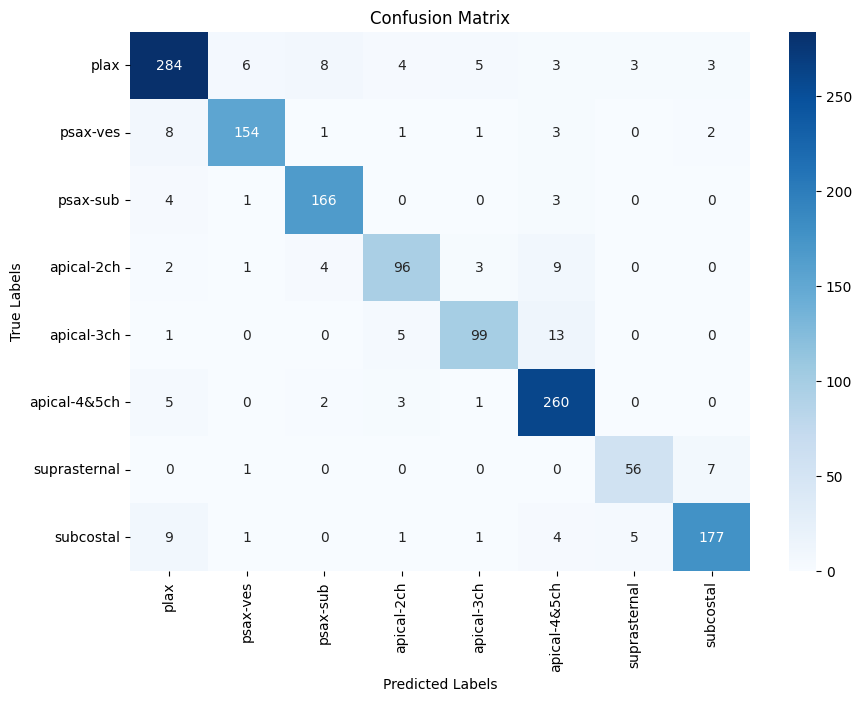

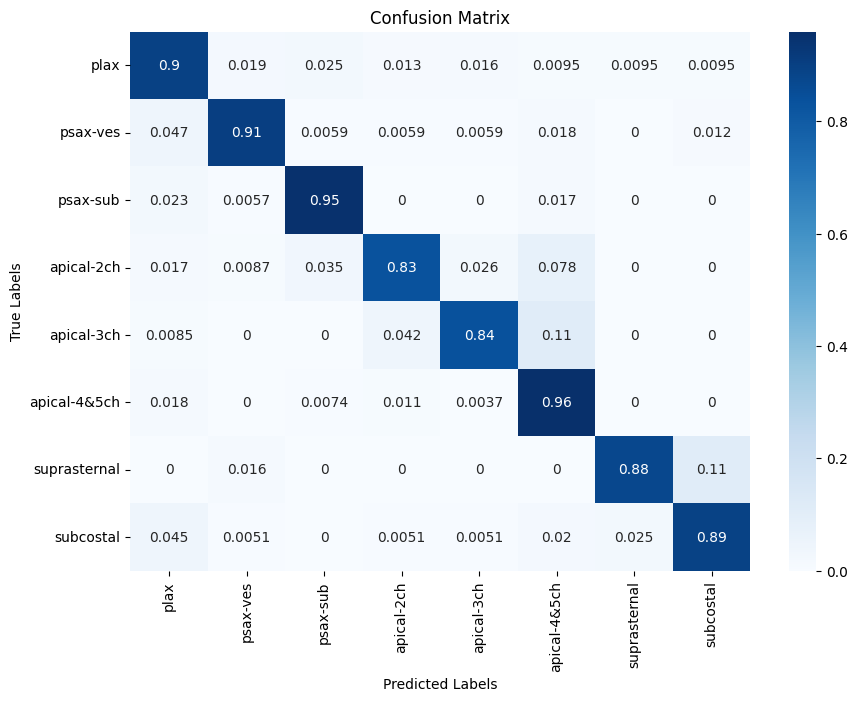

In [147]:
confusion_matrix_plt(true_labels, pred_labels)